# Dive Prediction - First Time Passage

*Predicting Seabird Diving Behaviour from GPS data*

This notebook predicts dive with First Time Passage Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.trip import * 

In [2]:
data_test = pd.read_csv('./data/data_test.csv')

## Empirical parameters 

In [3]:
## compute distance matrixes
list_trip = []
for i in data_test.trip.unique():
    t = data_test[data_test.trip == i]
    
    trip = Trip(t)
    trip.compute_dist_matrix()
    list_trip.append(trip)

In [4]:
## compute first time passage
radius = 250

list_ftp = []
for trip in list_trip:
    ftp = trip.first_time_passage(radius)
    list_ftp.append(ftp)

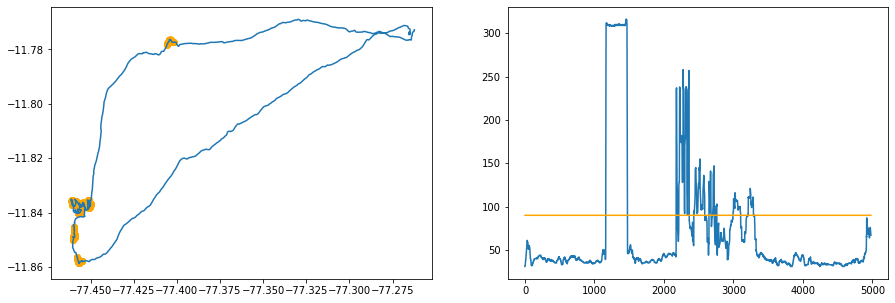

In [5]:
time_threshold = 90

i = 0

trip = list_trip[i]
ftp = list_ftp[i]

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(np.array(trip.df.lon), np.array(trip.df.lat))
plt.scatter(trip.df.lon.values[ftp>time_threshold], \
            trip.df.lat.values[ftp>time_threshold], c = 'orange')

plt.subplot(1,2,2)
plt.plot(ftp)
plt.plot(time_threshold*np.ones(len(ftp)), c = 'orange')

## Change resolution

In [6]:
def change_resolution(list_trip, list_ftp, time_threshold):
    
    dive_real = []
    dive_estim = []
    for i in range(len(list_trip)):

        trip = list_trip[i]
        estim_dive =  1*(list_ftp[i]>time_threshold)

        real = np.array([np.max(trip.df.dive[i:i+10]) for i in range(len(trip.df)) if i%10 == 0])
        estim = np.array([np.max(estim_dive[i:i+10]) for i in range(len(trip.df)) if i%10 == 0])

        dive_real.append(real)
        dive_estim.append(estim)
        
    return (dive_real, dive_estim)

In [7]:
(dive_real, dive_estim) = change_resolution(list_trip, list_ftp, time_threshold)

## Score

In [8]:
def get_score(real, estim):
    # globally
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])
    return (true_positive, true_negative)

In [9]:
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)
(true_positive, true_negative) =  get_score(all_real, all_estim)
(true_positive, true_negative)

(0.6170212765957447, 0.7981132075471697)

(0.6428571428571429, 0.8123711340206186)
(0.7142857142857143, 0.9045801526717557)
(0.16666666666666666, 0.9203821656050956)
(0.75, 0.5921787709497206)
(0.5454545454545454, 0.768)
(0.36363636363636365, 0.8362573099415205)
(0.6923076923076923, 0.8035714285714286)


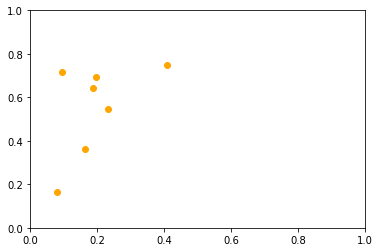

In [10]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    (true_positive, true_negative) =  get_score(real, estim)
    
    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    
    print((true_positive, true_negative))

# ROC curve

Change the decision threshold

In [11]:
TP = []
FP = []
for tt in range(30, 300, 10):  
    (dive_real, dive_estim) = change_resolution(list_trip, list_ftp, tt)
    all_real = 1* (np.hstack(dive_real)> 0)
    all_estim = 1* (np.hstack(dive_estim) > 0)
    (true_positive, true_negative) =  get_score(all_real, all_estim)
    
    TP.append(true_positive)
    FP.append(1-true_negative)

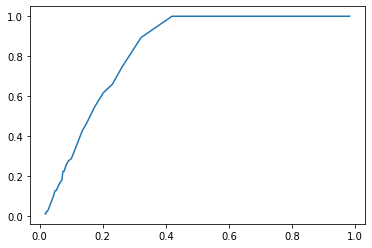

In [12]:
plt.plot(np.array(FP), np.array(TP))

In [13]:
data = {'model': 'ftp',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame(data, columns = ['model','FP','TP'])

df.to_csv('./roc/roc_ftp.csv', index = False)